Start of 6.2 Random Walk 2018-09-11 07:56:38.740621
Start of 6.3 Random Walk Under Batch Updating 2018-09-11 07:56:50.423704

End of Random Walk 2018-09-11 07:58:17.761052
Running Time 0:01:39.020431


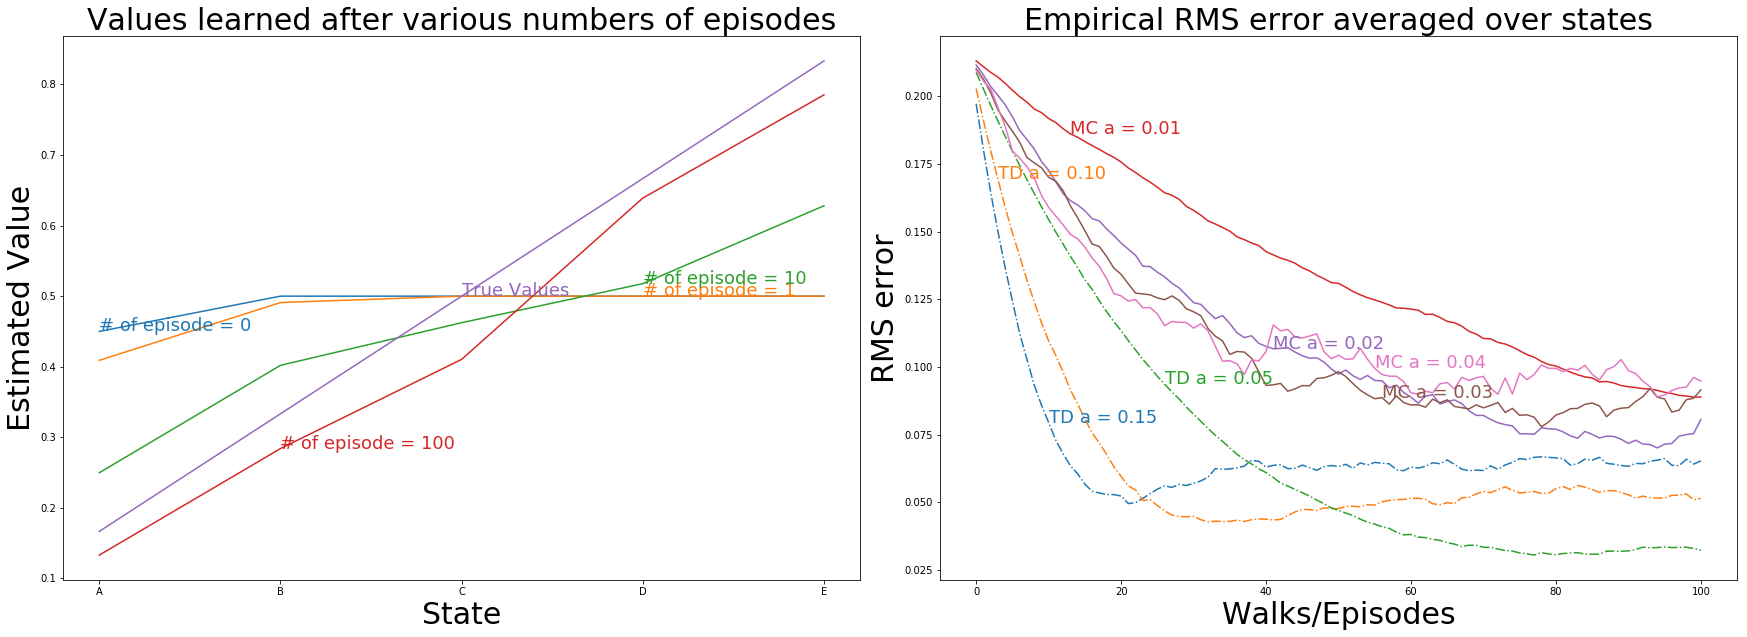

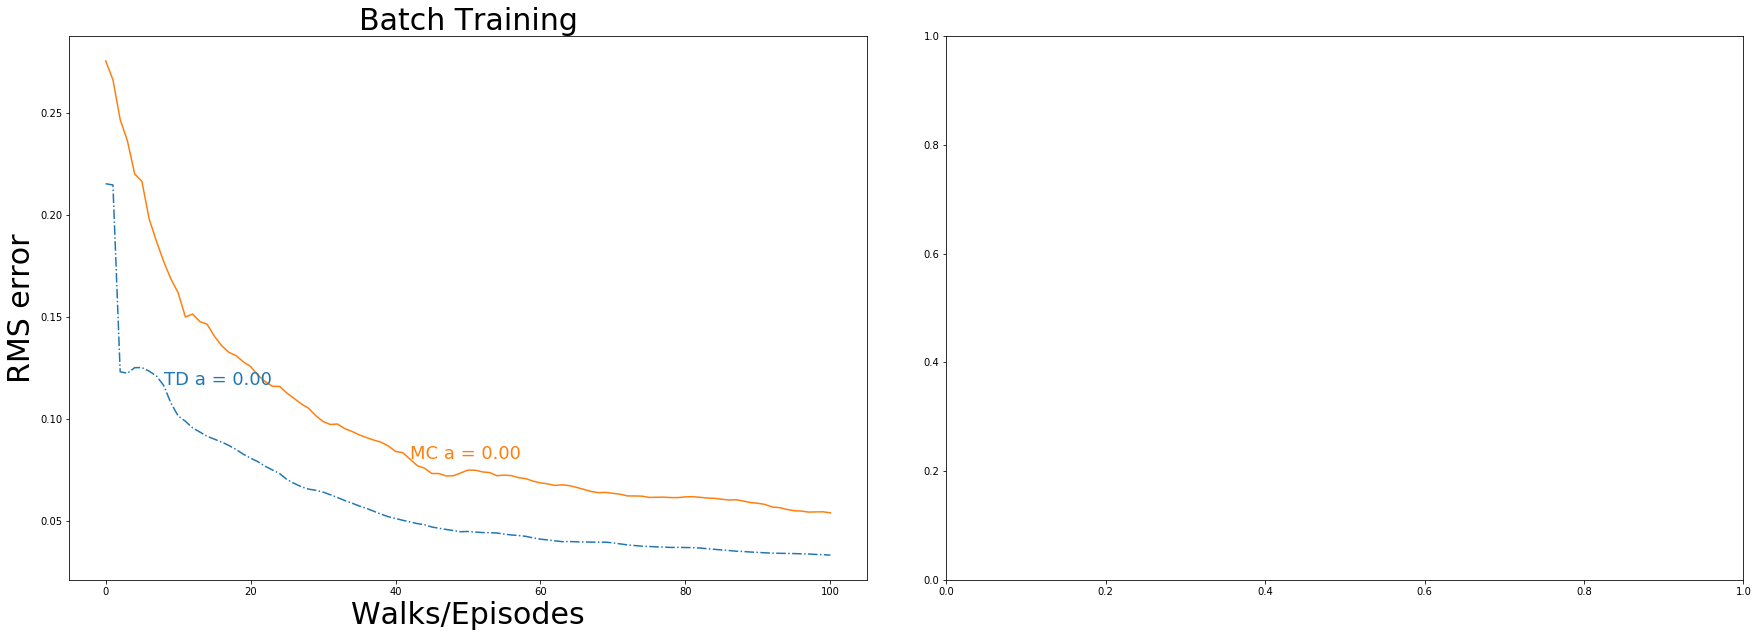

In [151]:
"""Example 6.2 Random Walk & Example 6.3: Random walk under batch updating
Author : SeongJin Yoon
"""
import numpy as np
import random
import datetime as dt
import matplotlib.pyplot as plt
import math

class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        self.len_axes = nrows*ncols
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        if self.len_axes != 1:
            self.axes = self.axes.flatten()

    def get_axes(self, idx):
        if self.len_axes != 1: 
            ax = self.axes[self.fig_idx]
        else:
            ax = self.axes
        return ax
    
    def draw_mline_begin(self, labels):       
        ax = self.get_axes(self.fig_idx)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        
        return ax
        
    def draw_mline(self, ax, pos, data, label, linestyle='solid'):
        lines = ax.plot(pos, data, label=label, linestyle=linestyle)
        
        pivot_idx = random.randint(0, (len(data)*2)//3)
        x_pos = pos[pivot_idx]
        y_pos = data[pivot_idx]
        ax.text(x_pos, y_pos, label, color = lines[0].get_color(), size=18)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax = self.get_axes(self.fig_idx)
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def show(self):
        plt.show()

class Action():
    left = 0
    right = 1
    
    @staticmethod
    def to_str(action):
        assert action == Action.left or action == Action.right 
        strlist = ["left", "right"]
        return strlist[action]

class RandomWalk():
    def __init__(self):
        self.state_list = ['LM', 'A', 'B', 'C', 'D', 'E', 'RM']
        self.start = 'C'
        self.start_idx = self.state_list.index(self.start)
        self.terminal = ['LM', 'RM']
        self.init_policy()
        self.true_value = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 0]
    
    def init_policy(self):
        self.policy = np.full((7,2), 0.5)
        
        # terminal state
        for state in self.terminal:
            state_idx = self.state_list.index(state)
            self.policy[state_idx, Action.left] = 0
            self.policy[state_idx, Action.right] = 0

    def init_value(self):
        V = np.full(7, 0.5)
        for state in self.terminal:
            state_idx = self.state_list.index(state)
            V[state_idx] = 0
    
        return V
    
    def get_reward(self, state_idx):
        state = self.state_list[state_idx]
        if state == 'RM':
            return 1
        return 0
    
    def is_terminal(self, state_idx):
        state = self.state_list[state_idx]
        if state in self.terminal:
            return True
        return False
    
    def get_action_idx(self, state_idx):
        best_idx = np.argmax(self.policy[state_idx])
        best = self.policy[state_idx, best_idx]
        max_list = np.argwhere(self.policy[state_idx] == best)
        max_list = max_list.flatten()
        action_idx = max_list[random.randint(0,len(max_list)-1)]
        return action_idx
        
    def do_action(self, state_idx, action_idx):
        
        if self.is_terminal(state_idx):
            return state_idx, self.reward()
            
        next_state_idx = 0
        if action_idx == Action.left:
            next_state_idx = state_idx - 1
        elif action_idx == Action.right:
            next_state_idx = state_idx + 1

        return next_state_idx, self.get_reward(next_state_idx)
    
     
    def temporal_difference(self, V, alpha, batch=False):
        discount = 1
        state_idx = self.start_idx
        trajectory = []
        
        while self.is_terminal(state_idx) is False:
            
            action_idx = self.get_action_idx(state_idx)
            next_state_idx, reward = self.do_action(state_idx, action_idx)

            if batch:
                trajectory.append([state_idx, reward])
            else:
                error = reward + discount*V[next_state_idx] - V[state_idx]
                V[state_idx] += alpha*error

            state_idx = next_state_idx
        
        trajectory.append([state_idx, 0])
        
        return trajectory

    
    def batch_updating(self, method, V, trajectories, alpha):        
        discount = 1
        count = 1
        while True:
            acc_error = np.zeros(7)
            for trajectory in trajectories:
                
                if method == 'TD':
                    for step in range(len(trajectory)-1):
                        state_idx, reward = trajectory[step]
                        next_state_idx, _ = trajectory[step+1]
                        error = reward + discount*V[next_state_idx] - V[state_idx]
                        acc_error[state_idx] += error
                else:
                    for step in range(len(trajectory)-1):
                        state_idx, discounted_return = trajectory[step]
                        error = discounted_return - V[state_idx] 
                        acc_error[state_idx] += error
                        
            if np.sum(np.abs(acc_error*alpha)) < 1e-3:
                break

            V += acc_error*alpha
            assert V[0] == 0 and V[6] == 0

            count += 1

    def constant_alaph_mc(self, V, alpha, batch=False):
        
        episode, reward = self.generate_episode()
        
        discount = 1
        discounted_return = 0
        next_reward = reward
        trajectory = []
 
        for step in range(len(episode)-1, -1, -1):
            state_idx, action_idx, reward = episode[step]
            discounted_return = next_reward + discount*discounted_return
            if batch:
                trajectory.append([state_idx, discounted_return])
            else:
                error = discounted_return - V[state_idx]
                V[state_idx] += alpha*error
                
            next_reward = reward
            
        return trajectory            
            
    def generate_episode(self):           
        episode = []
        state_idx = self.start_idx
        reward = 0
        while True:
            action_idx = self.get_action_idx(state_idx)
            episode.append([state_idx, action_idx, reward])
            next_state_idx, reward = self.do_action(state_idx, action_idx)
            if self.is_terminal(next_state_idx):
                break
            state_idx = next_state_idx

        return episode, reward
    
    def calc_rms_error(self, V):
        
        error = (self.true_value - V)[1:len(V)]
        rms_error =  math.sqrt(np.mean(error**2))
            
        return rms_error
    
    def draw_rms_plot(self, ax, method, alpha, batch=False):
        num_runs = 100
        num_episode = 100+1
        episode_list = list(range(num_episode))
        
        avg_rms_error = np.zeros(num_episode)
        
        for run in range(0, num_runs):
            V = self.init_value()
            rms_error_list = np.zeros(num_episode)
            trajectories = []
            
            for episode_idx in range(num_episode):
                if method == 'TD':
                    trajectory = self.temporal_difference(V, alpha, batch)
                else:
                    trajectory = self.constant_alaph_mc(V, alpha, batch)
                
                if batch:
                    trajectories.append(trajectory)
                    self.batch_updating(method, V, trajectories, alpha)
                    
                rms_error_list[episode_idx] = self.calc_rms_error(V)
                
            avg_rms_error += rms_error_list
   
        avg_rms_error /= num_runs
        
        label = method + " a = %.2f" % (alpha)
        linestyle = 'dashdot' if method == 'TD' else 'solid'
        self.plot.draw_mline(ax, episode_list, avg_rms_error, label, linestyle)
        
    def draw_td_value_plot(self):
        labels = ['State', 'Estimated Value', 
                    'Values learned after various numbers of episodes']
        ax = self.plot.draw_mline_begin(labels)   
    
        alpha = 0.1
        
        num_episode = 100+1
        V = self.init_value()
    
        for episode_idx in range(num_episode):
            self.temporal_difference(V, alpha)
            label = "# of episode = %d" % (episode_idx)
            if episode_idx in [0, 1, 10, 100]:
                self.plot.draw_mline(ax, self.state_list[1:-1], V[1:-1], label)
        
        label = "True Values"
        self.plot.draw_mline(ax, self.state_list[1:-1], 
                        self.true_value[1:-1], label)
        self.plot.draw_mline_end()
        
    def draw_online_plot(self):
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,10))
       
        # left figure
        self.draw_td_value_plot()
    
        # right figure
        labels = ['Walks/Episodes', 'RMS error', 
                    'Empirical RMS error averaged over states']
        ax = self.plot.draw_mline_begin(labels)   
        
        for alpha in [0.15, 0.1, .05]:
            self.draw_rms_plot(ax, 'TD', alpha)

        for alpha in [0.01, 0.02, 0.03, 0.04]:
            self.draw_rms_plot(ax, 'MC', alpha)
                
        self.plot.draw_mline_end()


    def draw_batch_plot(self):
        
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,10))
        
        labels = ['Walks/Episodes', 'RMS error', 'Batch Training']
        ax = self.plot.draw_mline_begin(labels)   

        # TD batching update
        alpha = 0.001
        self.draw_rms_plot(ax, 'TD', alpha, True)

        # MC batching update
        self.draw_rms_plot(ax, 'MC', alpha, True)

        self.plot.draw_mline_end()

if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start of 6.2 Random Walk", begin_time)
    randomwalk = RandomWalk()
    randomwalk.draw_online_plot()
    
    print("Start of 6.3 Random Walk Under Batch Updating", dt.datetime.now())
    s_time = dt.datetime.now()
    randomwalk.draw_batch_plot()
    
    end_time = dt.datetime.now()
    print()
    print("End of Random Walk", end_time)
    print("Running Time", end_time - begin_time)